# Segmentation

This notebook is for segmenting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [2]:
import cellpose
import napari
from macrohet import dataio, tile, visualise, tools
import os, glob
from tqdm.auto import tqdm
import numpy as np
from skimage import morphology, measure 
import btrack
import dask.array as da
# define tracking scale factor
scale_factor = 1/5.04

In [3]:
import napari_animation

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/ND0000'
# base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/NDXXXX_optimisation/ND0000__2023-08-04T15_27_41-Measurement 1/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/NDXXXX_optimisation/ND0000__2023-08-04T15_27_41-Measurement 1/'
# metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/243648 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0203K1F1P1R1,Ok,r02c03f01p01-ch1sk1fk1fl1.tiff,2,3,1,1,0,1,1,...,0,0.135205805,0,2023-08-04T15:28:16.5+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
1,0203K1F1P1R2,Ok,r02c03f01p01-ch2sk1fk1fl1.tiff,2,3,1,1,0,2,1,...,0,0.135205805,0,2023-08-04T15:28:16.5+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
2,0203K1F1P1R3,Ok,r02c03f01p01-ch3sk1fk1fl1.tiff,2,3,1,1,0,3,1,...,0,0.135205805,0,2023-08-04T15:28:16.767+01:00,640,706,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
3,0203K1F1P2R1,Ok,r02c03f01p02-ch1sk1fk1fl1.tiff,2,3,1,2,0,1,1,...,2E-06,0.135207802,0,2023-08-04T15:28:17.047+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
4,0203K1F1P2R2,Ok,r02c03f01p02-ch2sk1fk1fl1.tiff,2,3,1,2,0,2,1,...,2E-06,0.135207802,0,2023-08-04T15:28:17.047+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243643,0310K376F9P2R2,Ok,r03c10f09p02-ch2sk376fk1fl1.tiff,3,10,9,2,375,2,1,...,2E-06,0.135064006,337503.973,2023-08-08T13:15:47.533+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243644,0310K376F9P2R3,Ok,r03c10f09p02-ch3sk376fk1fl1.tiff,3,10,9,2,375,3,1,...,2E-06,0.135064006,337503.973,2023-08-08T13:15:47.8+01:00,640,706,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243645,0310K376F9P3R1,Ok,r03c10f09p03-ch1sk376fk1fl1.tiff,3,10,9,3,375,1,1,...,4E-06,0.135066003,337503.973,2023-08-08T13:15:48.08+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243646,0310K376F9P3R2,Ok,r03c10f09p03-ch2sk376fk1fl1.tiff,3,10,9,3,375,2,1,...,4E-06,0.135066003,337503.973,2023-08-08T13:15:48.097+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
# metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
metadata_path = glob.glob(os.path.join(base_dir, 'Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
# TEMP FIX FOR BUG IN ASSAY LAYOUT READER - ends up displaying more rows cols then there are so
assay_layout = assay_layout.loc[[idx for idx in assay_layout.index if str(idx[0]) in list(metadata['Row'].unique()) and str(idx[1]) in list(metadata['Col'].unique())]]
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Cell Count Staining Infection
Row Column                              
2   3           50000    False     False
    4           50000    False      True
    9           50000     True     False
    10          50000     True      True
3   3           25000    False     False
    4           25000    False      True
    9           25000     True     False
    10          25000     True      True

### Define row and column of choice

In [4]:
row = 2
column = 10

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [5]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/ND0000'
image_dir = os.path.join(base_dir, 'Images')


In [6]:
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='max_proj',
                             set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (2, 10, 'max_proj', 1, None) 


Stitching images together:   0%|          | 0/1128 [00:00<?, ?it/s]

### Or load from Zarr

In [49]:
images = da.from_zarr('/mnt/DATA/macrohet/macrohet_images/ND0000/zarr/2.10_gfp_rfp.zarr/')
images

dask.array<from-zarr, shape=(376, 2, 3, 6048, 6048), dtype=uint16, chunksize=(1, 2, 3, 6048, 6048), chunktype=numpy.ndarray>

# Segment 
Let us start simple, only segmenting the lowest Z plane where the largest regions of cells are and only ch1 (GFP) where the GFP signal is.

In [11]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

def segment(img, ):
    masks, flows, styles, diams = model.eval(img, diameter=350, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Oct 26 15:01:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:65:00.0  On |                  Off |
| 74%   86C    P2             287W / 300W |   5840MiB / 49140MiB |     93%      D

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>> cyto << model set to be used


>>> GPU activated? YES


INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


# Testing ND0000

In [19]:
masks_stack = []
for t in tqdm(range(len(images)), total = 376):
    masks, flows, styles, diams = model.eval(images[t,0,...].compute().compute(), diameter=75, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    masks_stack.append(masks)
masks_stack = np.stack(masks_stack, axis = 0)

  0%|          | 0/376 [00:00<?, ?it/s]

INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.89 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.13 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.90 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.04 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 16.32 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.37 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.72 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.63 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.77 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.75 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.92 sec
INFO:cellp

NameError: name 'np' is not defined

In [21]:
masks_stack = np.stack(masks_stack, axis = 0)

In [22]:
np.save('/mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default.npy', masks_stack)

# Load masks

In [8]:
masks = np.load('/mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default.npy')

In [53]:
masks.shape

(376, 6048, 6048)

# Tidy up masks

In [9]:
morphology.remove_small_objects

<function skimage.morphology.misc.remove_small_objects(ar, min_size=64, connectivity=1, *, out=None)>

In [10]:
masks = np.zeros_like(masks_stack)
for t, frame in tqdm(enumerate(masks_stack), total = 376):
    tidy_mask = morphology.remove_small_objects(frame, min_size=2222)
    masks[t] = tidy_mask

  0%|          | 0/376 [00:00<?, ?it/s]

In [59]:
import sys
sys.getsizeof(masks)/1024/1024/1024

25.61778272688389

In [55]:
masks.shape

(376, 6048, 6048)

## Binarise masks

In [68]:
from importlib import reload

In [73]:
reload(tools)

<module 'macrohet.tools' from '/home/dayn/analysis/macrohet/macrohet/tools.py'>

In [74]:
semantic_masks = np.zeros_like(masks, dtype=np.uint8)
for t, frame in tqdm(enumerate(masks), total = 376):
    semantic_mask = tools.instance_to_semantic(masks[t])
    semantic_masks[t] = semantic_mask
    break

  0%|          | 0/376 [00:00<?, ?it/s]

Iterating over segments:   0%|          | 0/926 [00:00<?, ?it/s]

In [ ]:
viewer

In [77]:
recolored_segmentation.shape

(376, 6048, 6048)

# Track

In [17]:
# define tracking scale factor
scale_factor = 1/5.04

# define features to use for tracking 
features = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "mean_intensity",
    ]

# define tracker config fn to use, using a prob_not_assign = 0.1
config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
# define tracker config fn to use
# config_fn = '/home/dayn/analysis/btrack/models/particle_config.json'


def track(objects, masks, config_fn, search_radius = 20):

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks

    return tracks

In [20]:
intensity_image = tile.compile_mosaic(image_dir, 
                                     metadata, 
                                     row, column, 
                                     set_plane='max_proj')

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (2, 10, 'max_proj', None, None) 


Stitching images together:   0%|          | 0/3384 [00:00<?, ?it/s]

In [55]:
import dask.array as da

In [73]:
intensity_image = da.stack([intensity_image[:,0,...], intensity_image[:,1,...]], axis = -1)

In [21]:
intensity_image = intensity_image[:,2,...]

In [18]:
masks.shape

(376, 6048, 6048)

In [19]:
import btrack

In [20]:
btrack.__version__

'0.6.1.dev116'

In [21]:
objects = btrack.utils.segmentation_to_objects(segmentation=masks,
                                               # intensity_image=intensity_image, 
                                               # properties=features,
                                               scale=(scale_factor,scale_factor),
                                               use_weighted_centroid=False, 
                                               )

[INFO][2023/10/30 10:29:48 AM] Localizing objects from segmentation...
INFO:btrack.io._localization:Localizing objects from segmentation...
progress: 100%|██████████████████████████████████████████████| 376/376 [07:19<00:00,  1.17s/it]
[INFO][2023/10/30 10:37:07 AM] Objects are of type: <class 'dict'>
INFO:btrack.io.utils:Objects are of type: <class 'dict'>
[INFO][2023/10/30 10:37:08 AM] ...Found 283310 objects in 376 frames.
INFO:btrack.io._localization:...Found 283310 objects in 376 frames.


In [22]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
    # configure the tracker using a config file
    tracker.configure(config_fn)
    # set max search radius
    tracker.max_search_radius =  20
    # define tracking method
    # tracker.tracking_updates = ["MOTION", "VISUAL"]
    # redefine features so that both channels are included in track measurements
    # tracker.features = list(objects[0].properties.keys())
    # append the objects to be tracked
    tracker.append(objects)
    # set the tracking volume
    tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
    # track them (in interactive mode)
    tracker.track(step_size=25)
    # generate hypotheses and run the global optimizer
    tracker.optimize()
    # store the tracks
    tracks = tracker.tracks

[INFO][2023/10/30 10:37:08 AM] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/10/30 10:37:08 AM] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2023/10/30 10:37:08 AM] Loading configuration file: /home/dayn/analysis/models/btrack/particle_config_pnassign.json
INFO:btrack.config:Loading configuration file: /home/dayn/analysis/models/btrack/particle_config_pnassign.json
[INFO][2023/10/30 10:37:08 AM] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[INFO][2023/10/30 10:37:09 AM] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2023/10/30 10:37:09 AM] Update using: ['MOTION']
INFO:btrack.core:Update using: ['MOTION']
[INFO][2023/10/30 10:37:10 AM] Tracking objects in frames 0 to 24 (of 376)...
INFO:btrack.core:Tracking objects in frames 0 to 24 (of 376)...
[INFO]

GLPK Integer Optimizer 5.0
146128 rows, 154288 columns, 235512 non-zeros
154288 integer variables, all of which are binary
Preprocessing...
73064 rows, 154288 columns, 235512 non-zeros
154288 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 73064
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
73064 rows, 154288 columns, 235512 non-zeros
*     0: obj =   4.540506459e+05 inf =   0.000e+00 (72435)
Perturbing LP to avoid stalling [1196]...
*  1874: obj =   4.337607460e+05 inf =   0.000e+00 (69532)
*  3797: obj =   4.140556193e+05 inf =   0.000e+00 (66654)
*  5503: obj =   3.989330744e+05 inf =   0.000e+00 (63830)
*  7046: obj =   3.867421167e+05 inf =   0.000e+00 (61044)
*  8535: obj =   3.761816096e+05 inf =   0.000e+00 (58251) 1
*  9970: obj =   3.669884265e+05 inf =   0.000e+00 (55294)
* 11358: obj =   3.589829318e+05

[INFO][2023/10/30 10:41:07 AM] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


# Save out tracksw

In [29]:
# save out 
with btrack.io.HDF5FileHandler('/mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5', 
                                   'w', 
                                   obj_type='obj_type_1'
                                   ) as writer:
#             writer.write_objects(objects)
        writer.write_tracks(tracks)
        writer.write_segmentation(masks)

[INFO][2023/10/30 10:52:21 am] Opening HDF file: /mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5...
[INFO][2023/10/30 10:52:24 am] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2023/10/30 10:52:24 am] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2023/10/30 10:52:24 am] Loading objects/obj_type_1 (283308, 5) (283308 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (283308, 5) (283308 filtered: None)
[INFO][2023/10/30 10:52:36 am] Writing tracks/obj_type_1
INFO:btrack.io.hdf:Writing tracks/obj_type_1
[INFO][2023/10/30 10:52:36 am] Writing dummies/obj_type_1
INFO:btrack.io.hdf:Writing dummies/obj_type_1
[INFO][2023/10/30 10:52:36 am] Writing LBEP/obj_type_1
INFO:btrack.io.hdf:Writing LBEP/obj_type_1
[INFO][2023/10/30 10:52:36 am] Writing fates/obj_type_1
INFO:btrack.io

# Load tracks

In [9]:
# save out 
with btrack.io.HDF5FileHandler('/mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5', 
                                   'r', 
                                   obj_type='obj_type_1'
                                   ) as reader:
#             writer.write_objects(objects)
        tracks = reader.tracks
        masks = reader.segmentation

[INFO][2023/10/30 11:24:08 AM] Opening HDF file: /mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5...
[INFO][2023/10/30 11:24:08 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/10/30 11:24:08 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/10/30 11:24:08 AM] Loading objects/obj_type_1 (283308, 5) (283308 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (283308, 5) (283308 filtered: None)
[INFO][2023/10/30 11:24:59 AM] Loading segmentation (376, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (376, 6048, 6048)
[INFO][2023/10/30 11:24:59 AM] Closing HDF file: /mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default_tracks.h5


In [14]:
masks.shape

(376, 6048, 6048)

In [15]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [16]:
recolored_segmentation = btrack.utils.update_segmentation(masks, tracks, scale= (1/scale_factor, 1/scale_factor))

In [17]:
viewer = napari.Viewer()

viewer.add_labels(masks)

viewer.add_tracks(napari_tracks, scale = (1/scale_factor, 1/scale_factor))

<Tracks layer 'napari_tracks' at 0x7fd01b177ac0>

In [18]:
viewer.add_labels(recolored_segmentation, )#scale = (1/scale_factor, 1/scale_factor)))

<Labels layer 'recolored_segmentation' at 0x7fce7ef7cd30>

In [35]:
viewer = napari.Viewer(title = 'exagerrated Z axis')

# viewer.add_labels(masks)?

viewer.add_tracks(napari_tracks, scale = (2, 1, 1))

<Tracks layer 'napari_tracks' at 0x7ff7339fdc40>

In [21]:
import matplotlib.pyplot as plt

In [19]:
print()

(0.0, 1000.0)

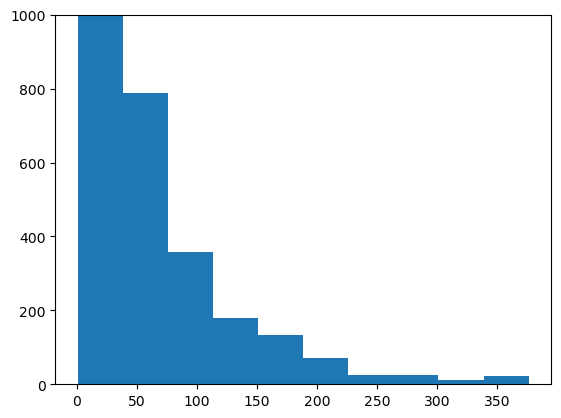

In [22]:
plt.hist([len(track) for track in tracks])
plt.ylim(0,1000)

In [25]:
from skimage.measure import label

In [26]:
np.max(label(masks[0]))

1037

In [33]:
filtered_tracks = [t for t in tracks if len(t) >= 60]

In [34]:
len(filtered_tracks)

1051

In [35]:
filtered_napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)


In [36]:
viewer.add_tracks(filtered_napari_tracks, scale = (1/scale_factor, 1/scale_factor))

<Tracks layer 'filtered_napari_tracks' at 0x7fce753709a0>

In [37]:
import dask.array as da

In [38]:
gfp_rfp = da.from_zarr('/mnt/DATA/macrohet/macrohet_images/ND0000/zarr/2.10_gfp_rfp.zarr')
gfp_rfp

dask.array<from-zarr, shape=(376, 2, 3, 6048, 6048), dtype=uint16, chunksize=(1, 2, 3, 6048, 6048), chunktype=numpy.ndarray>

# Testing different segmentation parameters 

In [36]:
### average cell diameter
diameters = [200, 250, 300]
### flow threshold, larger value means more ROIs (maybe ill fitting), lower means fewer ROIs 
flow_thresholds = [0.0, 0.4, 0.6, 0.8]
### cellprob_threshold, larger is is fewer ROIs, lower means more...? 
# cellprobs_thresholds = [-0.2, 0.0, 0.2]

In [34]:
import itertools

In [58]:
mask_dict = dict()
params = list(itertools.product(diameters, flow_thresholds))
for diameter, flow_threshold in tqdm(params, total = len(params)):
    mask_stack = []
    for timepoint in tqdm(images, total = len(images), leave = False):
        ### extract GFP channel and lowest Z plane from single time point
        gfp_z0_frame = timepoint[0,0,...]
        masks, flows, styles, diams = model.eval(gfp_z0_frame, diameter=diameter, channels=[0,0],
                                             flow_threshold=flow_threshold, cellprob_threshold=0)        
        mask_stack.append(masks)
    mask_images = da.stack(mask_stack, axis = 0) 
    mask_dict[(diameter, flow_threshold)] = mask_images

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [59]:
mask_dict

{(200,
  0.0): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.4): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.6): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.8): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.0): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.4): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.6): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.8): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (300,
 

In [62]:
import numpy as np

In [63]:
np.save('mask_dict.npy', mask_dict)

# Testing different segmentation parameters 

In [8]:
### average cell diameter
# diameters = [200, 250, 300]
diameters = [150, 225, 275, 325, 375]
### flow threshold, larger value means more ROIs (maybe ill fitting), lower means fewer ROIs 
# flow_thresholds = [0.0, 0.4, 0.6, 0.8]
flow_thresholds = [0.1, 0.2, 0.3, 0.5, 1, 1.2, 1.5]

### cellprob_threshold, larger is is fewer ROIs, lower means more...? 
# cellprobs_thresholds = [-0.2, 0.0, 0.2]

In [16]:
import itertools, os
import numpy as np

In [10]:
params = list(itertools.product(diameters, flow_thresholds))
len(params)

35

In [17]:
np.save(f'd{diameter}_ft{flow_threshold}_masks.npy', mask_images)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [22]:
for diameter, flow_threshold in tqdm(params, total = len(params)):
    if os.path.exists(f'd{diameter}_ft{flow_threshold}_masks.npy'):
        print(f'Found d{diameter}_ft{flow_threshold}_masks.npy, skipping to next params')
        continue
    mask_stack = []
    for timepoint in tqdm(images, total = len(images), leave = False):
        ### extract GFP channel and lowest Z plane from single time point
        gfp_z0_frame = timepoint[0,0,...]
        masks, flows, styles, diams = model.eval(gfp_z0_frame, diameter=diameter, channels=[0,0],
                                             flow_threshold=flow_threshold, cellprob_threshold=0)        
        mask_stack.append(masks)
    mask_images = da.stack(mask_stack, axis = 0) 
    np.save(f'd{diameter}_ft{flow_threshold}_masks.npy', mask_images)
    mask_dict[(diameter, flow_threshold)] = mask_images

  0%|          | 0/35 [00:00<?, ?it/s]

Found d150_ft0.1_masks.npy, skipping to next params
Found d150_ft0.2_masks.npy, skipping to next params
Found d150_ft0.3_masks.npy, skipping to next params
Found d150_ft0.5_masks.npy, skipping to next params
Found d150_ft1_masks.npy, skipping to next params
Found d150_ft1.2_masks.npy, skipping to next params
Found d150_ft1.5_masks.npy, skipping to next params
Found d225_ft0.1_masks.npy, skipping to next params
Found d225_ft0.2_masks.npy, skipping to next params
Found d225_ft0.3_masks.npy, skipping to next params
Found d225_ft0.5_masks.npy, skipping to next params
Found d225_ft1_masks.npy, skipping to next params
Found d225_ft1.2_masks.npy, skipping to next params
Found d225_ft1.5_masks.npy, skipping to next params
Found d275_ft0.1_masks.npy, skipping to next params
Found d275_ft0.2_masks.npy, skipping to next params
Found d275_ft0.3_masks.npy, skipping to next params
Found d275_ft0.5_masks.npy, skipping to next params
Found d275_ft1_masks.npy, skipping to next params
Found d275_ft1.2_m

  0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
mask_dict = dict()
mask_dict[(diameter, flow_threshold)] = mask_images

In [62]:
import numpy as np

In [63]:
np.save('mask_dict.npy', mask_dict)

In [57]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
viewer.add_labels(mask_images, 
                 )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'mask_images' at 0x7f995d5e5df0>